<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P7: Implémentez un modèle de scoring </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 2 : Modélisation** </span> </font> 

**Contexte**  
**Prêt à dépenser** est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
<img src="pretadepenser.png" width="200" height="200">
**Mission**   
* Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
* Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
* Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

Dans ce notebook, nous allos:
* Résoudre le problème de désiquilibre entre les classes.
* Implémenter un modèle de machine learning
* Chercher les meilleurs hyperparamètres par gridsearchCV
* .....

# Importation des données et des librairies Python pour DS

In [159]:
# ------------------------------------------
# Projet : Implémenter un modèle de scoring
# Données: https://www.kaggle.com/c/home-credit-default-risk/data
# Auteur : Rim BAHROUN
# Date: Avril 2023
# OpenClassrooms
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import os
import csv
import numpy as np
import pandas as pd
import re
import gc
import time
import timeit
from contextlib import contextmanager
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from sklearn.metrics import make_scorer, f1_score, fbeta_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import mlflow

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
import sys
print(sys.executable)

C:\ProgramData\Anaconda3\python.exe


In [18]:
%matplotlib inline
np.random.seed(27)
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
train_df = pd.read_csv('data/traited/df_train_35.csv')

In [6]:
train_df.head()

EXT_SOURCE_2  PREV_DAYS_DECISION_MEAN  BURO_MONTHS_BALANCE_SIZE_MEAN  \
0      0.262949              -606.000000                          13.75   
1      0.622246             -1305.000000                          24.75   
2      0.555912              -815.000000                          24.75   
3      0.650442              -272.444444                          24.75   
4      0.322738             -1222.833333                          24.75   

   DAYS_REGISTRATION  PREV_NAME_YIELD_GROUP_low_normal_MEAN  \
0            -3648.0                               1.000000   
1            -1186.0                               0.333333   
2            -4260.0                               0.000000   
3            -9833.0                               0.222222   
4            -4311.0                               0.000000   

   PREV_NAME_YIELD_GROUP_high_MEAN  REGION_POPULATION_RELATIVE  \
0                         0.000000                    0.018801   
1                         0.000000                    0.003541   
2                         0.000000                    0.010032   
3                         0.222222                    0.008019   
4                         0.500000                    0.028663   

   PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN  BURO_DAYS_CREDIT_MAX  \
0                                        0.000000                -103.0   
1                                        0.666667                -606.0   
2                                        1.000000                -408.0   
3                                        0.444444                -300.0   
4                                        0.833333               -1149.0   

   POS_MONTHS_BALANCE_MEAN  BURO_CREDIT_TYPE_Creditcard_MEAN  \
0               -10.000000                               0.5   
1               -43.785714                               0.5   
2               -25.500000                               0.0   
3                -9.619048                               0.2   
4               -33.636364                               0.0   

   CLOSED_DAYS_CREDIT_MAX  BURO_STATUS_0_MEAN_MEAN  HOUR_APPR_PROCESS_START  \
0                  -476.0                 0.406960                       10   
1                  -775.0                 0.436423                       11   
2                  -408.0                 0.436423                        9   
3                  -729.0                 0.436423                       17   
4                 -1149.0                 0.436423                       11   

   PREV_NAME_PRODUCT_TYPE_XNA_MEAN  \
0                         1.000000   
1                         0.666667   
2                         1.000000   
3                         0.555556   
4                         0.333333   

   PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN  \
0                                           0.000000    
1                                           0.333333    
2                                           0.000000    
3                                           0.111111    
4                                           0.500000    

   CC_AMT_CREDIT_LIMIT_ACTUAL_SUM  PREV_NAME_TYPE_SUITE_nan_MEAN  \
0                       3960000.0                       1.000000   
1                       3960000.0                       0.000000   
2                       3960000.0                       0.000000   
3                       1620000.0                       0.555556   
4                       3960000.0                       0.333333   

   CLOSED_DAYS_CREDIT_MEAN  ACTIVE_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MIN  \
0              -974.500000                 -1042.0               -1437.0   
1             -1665.666667                  -606.0               -2586.0   
2              -867.000000                  -764.0               -1326.0   
3             -1366.555556                  -764.0               -1827.0   
4             -1149.000000                  -764.0               -1149.0   

   EXT_SOURCE_3  EXT_SOURCE

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 35 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   EXT_SOURCE_2                                        307507 non-null  float64
 1   PREV_DAYS_DECISION_MEAN                             307507 non-null  float64
 2   BURO_MONTHS_BALANCE_SIZE_MEAN                       307507 non-null  float64
 3   DAYS_REGISTRATION                                   307507 non-null  float64
 4   PREV_NAME_YIELD_GROUP_low_normal_MEAN               307507 non-null  float64
 5   PREV_NAME_YIELD_GROUP_high_MEAN                     307507 non-null  float64
 6   REGION_POPULATION_RELATIVE                          307507 non-null  float64
 7   PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN      307507 non-null  float64
 8   BURO_DAYS_CREDIT_MAX                                307507 non-n

In [8]:
#train_df_99 = pd.read_csv('data/traited/df_train_99.csv')

In [9]:
#train_df_na = train_df_99.loc[:, train_df.columns]

In [172]:
train_df

EXT_SOURCE_2  PREV_DAYS_DECISION_MEAN  BURO_MONTHS_BALANCE_SIZE_MEAN  \
0           0.262949              -606.000000                      13.750000   
1           0.622246             -1305.000000                      24.750000   
2           0.555912              -815.000000                      24.750000   
3           0.650442              -272.444444                      24.750000   
4           0.322738             -1222.833333                      24.750000   
...              ...                      ...                            ...   
307502      0.681632              -273.000000                      24.750000   
307503      0.115992             -2497.000000                      24.750000   
307504      0.535722             -2380.000000                      29.250000   
307505      0.514163              -299.500000                      37.000000   
307506      0.708569              -587.625000                      26.636364   

        DAYS_REGISTRATION  PREV_NAME_YIELD_GROUP_low_normal_MEAN  \
0                 -3648.0                               1.000000   
1                 -1186.0                               0.333333   
2                 -4260.0                               0.000000   
3                 -9833.0                               0.222222   
4                 -4311.0                               0.000000   
...                   ...                                    ...   
307502            -8456.0                               0.000000   
307503            -4388.0                               1.000000   
307504            -6737.0                               0.000000   
307505            -2562.0                               0.500000   
307506            -5128.0                               0.250000   

        PREV_NAME_YIELD_GROUP_high_MEAN  REGION_POPULATION_RELATIVE  \
0                              0.000000                    0.018801   
1                              0.000000                    0.003541   
2                              0.000000                    0.010032   
3                              0.222222                    0.008019   
4                              0.500000                    0.028663   
...                                 ...                         ...   
307502                         1.000000                    0.032561   
307503                         0.000000                    0.025164   
307504                         1.000000                    0.005002   
307505                         0.500000                    0.005313   
307506                         0.250000                    0.046220   

        PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN  BURO_DAYS_CREDIT_MAX  \
0                                             0.000000                -103.0   
1                                             0.666667                -606.0   
2                                             1.000000                -408.0   
3                                             0.444444                -300.0   
4                                             0.833333               -1149.0   
...                                                ...                   ...   
307502                                        1.000000                -300.0   
307503                                        1.000000                -300.0   
307504                                        1.000000                -713.0   
307505                                        1.000000               -1104.0   
307506                                        0.875000                -363.0   

        POS_MONTHS_BALANCE_MEAN  ...  BURO_CREDIT_ACTIVE_Active_MEAN  \
0                    -10.000000  ...                        0.250000   
1                    -43.785714  ...                        0.250000   
2                    -25.500000  ...                        0.000000   
3                     -9.619048  ...                        0.375000   
4                    -33.636364  ...                    

In [3]:
target = 'TARGET'

In [175]:
X = train_df.drop(columns="SK_ID_CURR").loc[:, train_df.drop(columns="SK_ID_CURR").columns!=target]
Y = train_df.loc[:, train_df.columns==target]

In [12]:
#X_na = train_df_na.loc[:, train_df_na.columns!=target]

In [176]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [23]:
# X_train_na, X_valid_na, Y_train_na, Y_valid_na = train_test_split(X_na, Y, 
#                                                                 test_size=0.33, 
#                                                                 random_state=42)

In [177]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [178]:
Y_train = Y_train.values.ravel()
#clf = LogisticRegression().fit(X_train_std, Y_train)

In [19]:
clf_lr = LogisticRegression()

In [18]:
clf_lgbm = LGBMClassifier( #nthread=4,
                        n_estimators=10000,
                        learning_rate=0.02,
                        num_leaves=34,
                        colsample_bytree=0.9497036,
                        subsample=0.8715623,
                        max_depth=8,
                        reg_alpha=0.041545473,
                        reg_lambda=0.0735294,
                        min_split_gain=0.0222415,
                        min_child_weight=39.3259775,
                        verbose=-1, )

# Fonctions utiles

In [17]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = {:.3f}".format(accuracy_score(y_actual, y_predicted)))
    print("Precision = {:.3f}".format(precision_score(y_actual, y_predicted)))
    print("Recall = {:.3f}".format(recall_score(y_actual, y_predicted)))
    print("F1 Score = {:.3f}".format(f1_score(y_actual, y_predicted)))
    print("Fbeta Score = {:.3f}".format(fbeta_score(y_actual, y_predicted, beta=3.16)))
    pass

In [19]:
def generate_auc_roc_curve(clf, X_test, Y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

# Equilibrer les classes 

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64


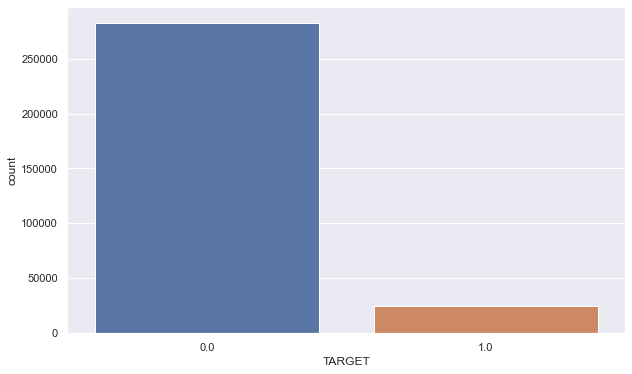

In [22]:
ax = sns.countplot(x='TARGET', data=train_df)
print(train_df['TARGET'].value_counts(normalize=True))

In [23]:
clf_lgbm.fit(X_train_std, Y_train)

LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, num_leaves=34, reg_alpha=0.041545473,
               reg_lambda=0.0735294, subsample=0.8715623, verbose=-1)

In [24]:
#Y_valid_pred = clf.predict(X_valid_std)

In [25]:
# print("Validation:")
# pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

In [26]:
# generate_model_report(Y_valid, Y_valid_pred)

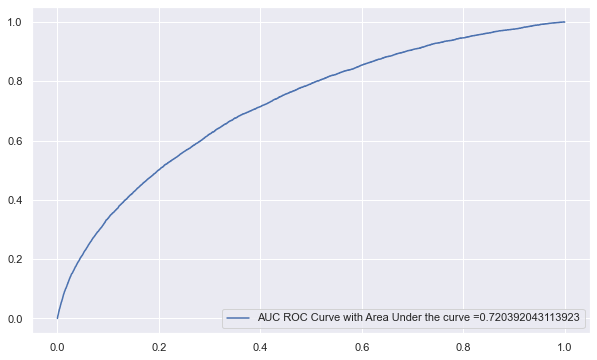

In [27]:
generate_auc_roc_curve(clf_lgbm, X_valid_std, Y_valid)

In [28]:
clf_lr.fit(X_train_std, Y_train)

LogisticRegression()

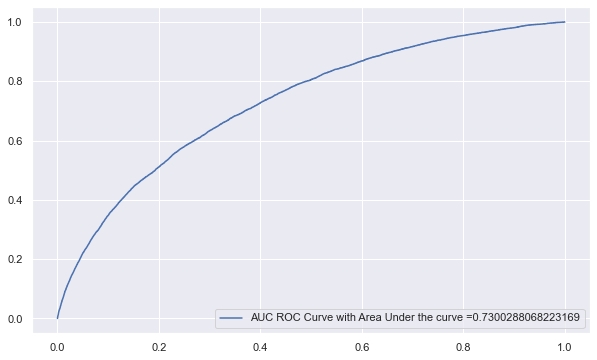

In [29]:
generate_auc_roc_curve(clf_lr, X_valid_std, Y_valid)

## Random undersampling

In [30]:
target = 'TARGET'
df = pd.DataFrame(X_train_std, columns=X_train.columns)
df[target] = Y_train
minority_class_len = len(df[df[target] == 1])
print(minority_class_len)

16655


In [31]:
majority_class_indices = df[df[target] == 0].index

In [32]:
random_majority_indices = np.random.choice(majority_class_indices,
                                           minority_class_len, 
                                           replace=False)
print(len(random_majority_indices))

16655


In [33]:
minority_class_indices = df[df[target] == 1].index

In [34]:
under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])

In [35]:
under_sample = df.loc[under_sample_indices]

In [36]:
under_sample[target].value_counts()

1.0    16655
0.0    16655
Name: TARGET, dtype: int64

In [37]:
X_train_std_us = under_sample.loc[:, df.columns!=target]
Y_train_us = under_sample.loc[:, df.columns==target]

In [39]:
clf_lgbm_us = clf_lgbm.fit(X_train_std_us, Y_train_us)
#Y_valid_us_pred = clf_us.predict(X_valid_std)

In [38]:
# print("Validation:")
# pd.crosstab(Y_valid_us_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

In [40]:
# generate_model_report(Y_valid, Y_valid_us_pred)

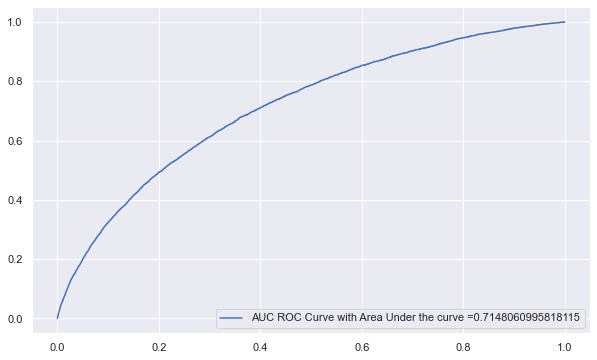

In [41]:
generate_auc_roc_curve(clf_lgbm_us, X_valid_std, Y_valid)

In [42]:
clf_lr_us = clf_lr.fit(X_train_std_us, Y_train_us)

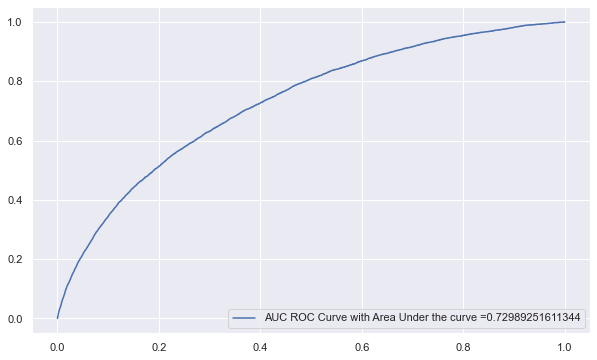

In [43]:
generate_auc_roc_curve(clf_lr_us, X_valid_std, Y_valid)

## Class_weight='balanced'

In [44]:
clf_lr_cw = LogisticRegression(class_weight='balanced').fit(X_train_std, Y_train)

In [45]:
clf_lgbm_cw = LGBMClassifier(
                        #nthread=4,
                        n_estimators=10000,
                        learning_rate=0.02,
                        num_leaves=34,
                        colsample_bytree=0.9497036,
                        subsample=0.8715623,
                        max_depth=8,
                        reg_alpha=0.041545473,
                        reg_lambda=0.0735294,
                        min_split_gain=0.0222415,
                        min_child_weight=39.3259775,
                        verbose=-1, 
                        class_weight='balanced').fit(X_train_std, Y_train)

In [58]:
from sklearn.utils import class_weight
class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)

array([0.54397383, 6.18519964])

In [46]:
# Y_valid_pred = clf_cw.predict(X_valid_std)

In [47]:
# print("Validation:")
# pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

In [48]:
# generate_model_report(Y_valid, Y_valid_pred)

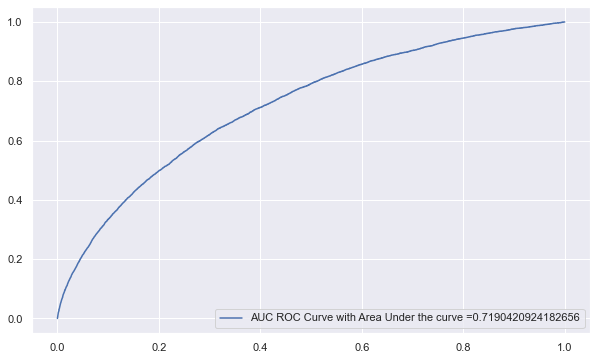

In [49]:
generate_auc_roc_curve(clf_lgbm_cw, X_valid_std, Y_valid)

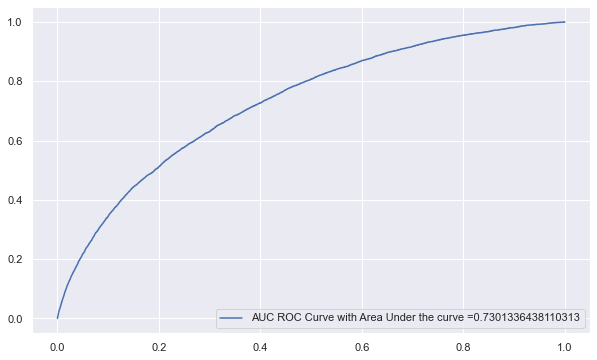

In [50]:
generate_auc_roc_curve(clf_lr_cw, X_valid_std, Y_valid)

In [60]:
# Define fbeta scorer with beta=3.16
scorer = make_scorer(fbeta_score, beta=3.16)

weights = np.linspace(0.05, 0.95, 10)
gsc = GridSearchCV(
    estimator=clf_lr,
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring=scorer,
    cv=3
)

grid_result = gsc.fit(X_train_std, Y_train)
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'class_weight': {0: 0.05, 1: 0.95}}


<AxesSubplot:xlabel='weight'>

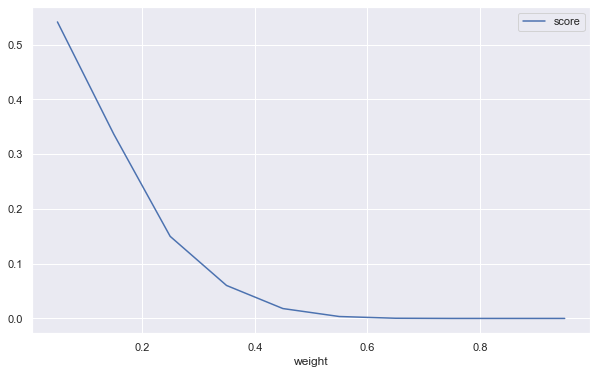

In [61]:
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
data_out.plot(x='weight')

In [62]:
clf_lr_cw_gs = LogisticRegression(**grid_result.best_params_).fit(X_train_std, Y_train)

In [64]:
# Y_valid_pred = clf_lr_cw_gs.predict(X_valid_std)

In [65]:
# print("Validation:")
# pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

In [66]:
# generate_model_report(Y_valid, Y_valid_pred)

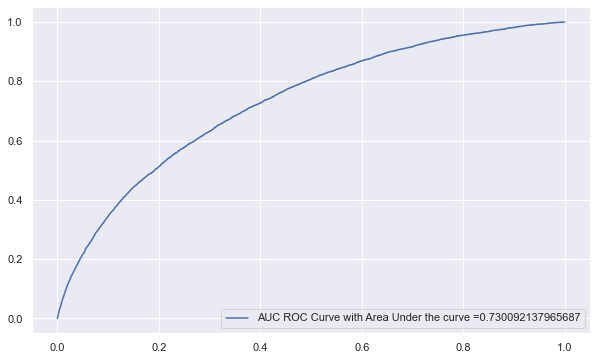

In [67]:
generate_auc_roc_curve(clf_lr_cw_gs, X_valid_std, Y_valid)

## SMOTE: Oversampling

In [68]:
unique, count = np.unique(Y_train, return_counts=True)
Y_train_dict_value_count = { k:v for (k,v) in zip(unique, count)}
Y_train_dict_value_count

{0.0: 189374, 1.0: 16655}

In [69]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_resample(X_train_std, Y_train)

In [70]:
pd.Series(y_train_res).value_counts()

0.0    189374
1.0    189374
dtype: int64

In [71]:
clf_lgbm_smote = clf_lgbm.fit(x_train_res, y_train_res)

In [72]:
# Y_valid_pred = clf_smote.predict(X_valid_std)

In [73]:
# print("Validation:")
# pd.crosstab(Y_valid_pred, Y_valid[target], rownames=['Predicted'], colnames=['Actual'])

In [74]:
# generate_model_report(Y_valid, Y_valid_pred)

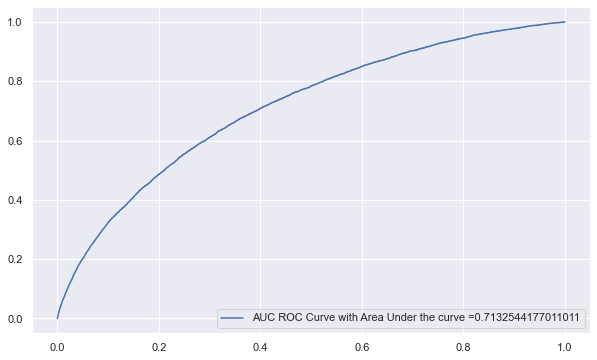

In [75]:
generate_auc_roc_curve(clf_lgbm_smote, X_valid_std, Y_valid)

In [76]:
clf_lr_smote = clf_lr.fit(x_train_res, y_train_res)

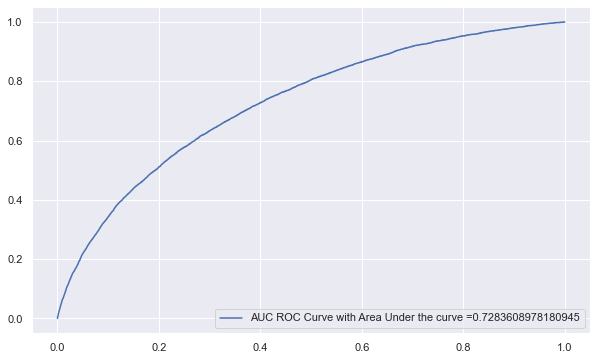

In [77]:
generate_auc_roc_curve(clf_lr_smote, X_valid_std, Y_valid)

In [78]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(random_state = 2)
# clf.fit(X_train,y_train)
# # y_pred = clf.predict(X_test)  # default threshold is 0.5
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3

# Modélisation

Les modèles de classification à optimiser :

* **Random Forest** :  
    * (n_estimators) Le nombre d'arbres
    * (max_depth) La profondeur maximale de l'arbre
    * (criterions) La fonction pour mesurer la qualité d'un split. « gini » pour l'impureté de Gini et « entropie » pour le gain d'informations.
* **Lightgbm** :
    * (max_depth) : contrôle la distance maximale entre le nœud racine de chaque arbre et un nœud feuille. Diminuer max_depth réduit le temps d'entraînement.
    * (num_leaves): définit le nombre maximal de nœuds par arbre. Diminuer num_leaves réduit le temps de entraînement.

In [9]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [10]:
mlflow.set_experiment("scoring")

2023/05/04 09:33:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/05/04 09:33:57 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='file:///D:/Documents/0Openclasseroom/P7_DS_03_04_2023/Implementez_un_modele_de_scoring/mlruns/1', creation_time=1683185643234, experiment_id='1', last_update_time=1683185643234, lifecycle_stage='active', name='scoring', tags={}>

## Baseline: DummyClassifier

In [90]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='Dummy_baseline'):
    params = {
        "strategy": 'most_frequent',
    }
    
    mlflow.set_tag("model_name", "Dummy")
    mlflow.log_params(params)
    
    dc = DummyClassifier(strategy='most_frequent', 
                         random_state=14)

    dc.fit(X_train_std, Y_train)
    
    y_pred_proba = dc.predict_proba(X_valid_std)[:, 1]
    dc_auc = roc_auc_score(Y_valid, y_pred_proba)
    print(dc_auc)
    
    mlflow.log_metric('Valid_auc', dc_auc)
    mlflow.sklearn.log_model(dc, "sk_models")  

0.5


## RandomForestClassifier

In [85]:
import logging

In [86]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='rf_baseline'):
    params = {
        "n_estimators": 100,
        "max_depth": 2
    }
    
    mlflow.set_tag("model_name", "RF")
    mlflow.log_params(params)
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=2, class_weight='balanced')
    rf.fit(X_train_std, Y_train)
    
    y_pred_proba = rf.predict_proba(X_valid_std)[:, 1]
    rf_auc = roc_auc_score(Y_valid, y_pred_proba)
    print(rf_auc)
    
    mlflow.log_metric('Valid_auc', rf_auc)
    mlflow.sklearn.log_model(rf, "sk_models")     

0.7031540513698096


## Recherche des hyperparamètres 

In [110]:
def custom_score_(y_true, y_pred):
    # coût d'un faux positif et un faux négatif
    cout_fp = 1
    cout_fn = 10
    
    # nombre total d'exemples positifs et négatifs
    n_pos = (y_true==1).sum()
    n_neg = (y_true==0).sum()
    # calcul du coût maximum possible
    max_cout = cout_fp * n_neg + cout_fn * n_pos
    
    # Calcul du nombre de faux positifs et faux négatifs
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    
    # calcul du coût total    
    cout = (cout_fp * fp + cout_fn * fn)  # / (fn + fp)
    cout_notmalise = cout/max_cout
    score = round(1 - cout_notmalise, 2)
    return score

custom_score = make_scorer(custom_score_, greater_is_better=True)

In [238]:
# Dictionnaire de regresseurs
classifier_grid = { 
               'Dummy': DummyClassifier(),     
               'LogisticReg': LogisticRegression(),
               'LGBM' : LGBMClassifier(),
               'Random Forest': RandomForestClassifier(),
               'Extra Tree' : ExtraTreesClassifier(),
            }
grid_params = { 'Dummy'        : {'strategy':['most_frequent']},
                'LogisticReg'  : {'class_weight':['balanced'],
                                 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag']},
                'Random Forest': {'class_weight':['balanced'],
                                  'max_depth': [3, 5, 7, 9],  #  The maximum depth of the tree.
                                  'n_estimators': [10, 200 , 500],  # ,  The number of trees in the forest. 
                                  'max_features': ['auto', 'sqrt', 'log2'],
                                  'criterion' :['gini', 'entropy']},
                'Extra Tree'   : {'class_weight':['balanced'],
                                  'n_estimators': [10, 200, 500],  # 
                                  'max_depth': [3, 5, 7, 9],  # 
                                  'max_features': ['auto', 'sqrt', 'log2'],
                                  'criterion' :['gini', 'entropy']},# 
                'LGBM'         : {'class_weight':['balanced'],
                                  'n_estimators': [150, 200, 500],  #  
                                  'learning_rate': [0.02, 0.08],  # 
                                  'max_depth': [5, 8, 9]}, #                                    
              } 

Dummy {'strategy': 'most_frequent'}
Dummy: AUROC = 0.5
Dummy: Score_metier = 0.53
Dummy: Accuracy = 0.92
Dummy: Recall = 0.0
Dummy: Presicion = 0.0
Dummy: run_time sec = 11.28
------------------
LogisticReg {'solver': 'liblinear', 'class_weight': 'balanced'}
LogisticReg: AUROC = 0.73
LogisticReg: Score_metier = 0.67
LogisticReg: Accuracy = 0.68
LogisticReg: Recall = 0.65
LogisticReg: Presicion = 0.15
LogisticReg: run_time sec = 120.75
------------------
LGBM {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.02, 'class_weight': 'balanced'}
LGBM: AUROC = 0.74
LGBM: Score_metier = 0.68
LGBM: Accuracy = 0.7
LGBM: Recall = 0.65
LGBM: Presicion = 0.16
LGBM: run_time sec = 447.29
------------------
Random Forest {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 9, 'criterion': 'entropy', 'class_weight': 'balanced'}
Random Forest: AUROC = 0.73
Random Forest: Score_metier = 0.67
Random Forest: Accuracy = 0.72
Random Forest: Recall = 0.61
Random Forest: Presicion = 0.16
Random Fo

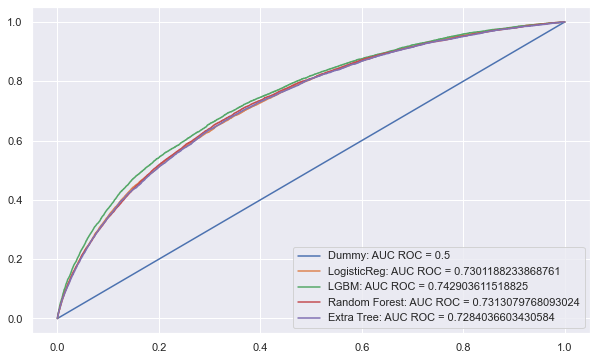

AUROC  Score_metier  Accuracy  Recall  Presicion  run_time sec  \
Dummy           0.50          0.53      0.92    0.00       0.00         11.28   
LogisticReg     0.73          0.67      0.68    0.65       0.15        120.75   
LGBM            0.74          0.68      0.70    0.65       0.16        447.29   
Random Forest   0.73          0.67      0.72    0.61       0.16       5244.94   
Extra Tree      0.73          0.67      0.68    0.65       0.15       3879.67   

                                                     best_params  
Dummy                              {'strategy': 'most_frequent'}  
LogisticReg    {'solver': 'liblinear', 'class_weight': 'balan...  
LGBM           {'n_estimators': 500, 'max_depth': 8, 'learnin...  
Random Forest  {'n_estimators': 200, 'max_features': 'log2', ...  
Extra Tree     {'n_estimators': 500, 'max_features': 'sqrt', ...

In [239]:
import warnings
warnings.filterwarnings("ignore")

# Les regressors sont testés 1 à 1 
df_Result = pd.DataFrame({})
mlflow.sklearn.autolog(disable=True)

fpr = dict()
tpr = dict()
thresholds = dict()

for name_clf, clf in classifier_grid.items() : 
    
    with mlflow.start_run(run_name=name_clf):
        model =  RandomizedSearchCV(clf,
                              grid_params[name_clf],
                              scoring = 'roc_auc',  # custom_score,
                              cv=10) 
        start_time = timeit.default_timer()
        model.fit(X_train_std, Y_train)

        y_pred_proba = model.predict_proba(X_valid_std)[:, 1]
        model_auc = roc_auc_score(Y_valid, y_pred_proba)
        y_pred = model.predict(X_valid_std)
        
        fpr[name_clf], tpr[name_clf], thresholds[name_clf] = roc_curve(Y_valid,  y_pred_proba)
        plt.plot(fpr[name_clf], tpr[name_clf], label= name_clf + ": AUC ROC = "+str(model_auc))
        plt.legend(loc=4)
        # calcul de l'erreur

        print(name_clf, str(model.best_params_) )
        
        metrics = {'AUROC': round(model_auc, 2),
                   'Score_metier': custom_score_(np.array(Y_valid.TARGET), y_pred.ravel()),
                   'Accuracy': round(accuracy_score(Y_valid, y_pred), 2),
                   'Recall': round(recall_score(Y_valid, y_pred), 2),
                   'Presicion': round(precision_score(Y_valid, y_pred), 2),
                   'run_time sec': round(timeit.default_timer() - start_time,2)}
        
        for key, val in metrics.items():
            df_Result.loc[name_clf, key] = val
            print(name_clf + ': ' + key + ' = ' + str(val))
        print("------------------")
        df_Result.loc[name_clf, 'best_params'] = str(model.best_params_)
        
        mlflow.set_tag("model_name", name_clf)
        mlflow.log_params(model.best_params_)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(model, "sk_models") 

plt.show()
df_Result

In [252]:
# df_Result.to_csv('data/traited/df_models_results.csv', index = True)

In [260]:
classifier_grid_opt = { 
               'Dummy': DummyClassifier(strategy='most_frequent'),     
               'LogisticReg': LogisticRegression(solver='liblinear', class_weight='balanced'),
               'LGBM' : LGBMClassifier(n_estimators=500,
                                       max_depth=8,
                                       learning_rate=0.02,
                                       class_weight='balanced'),
               'Random Forest': RandomForestClassifier(n_estimators=200,
                                                       max_features='log2',
                                                       max_depth=9,
                                                       criterion='entropy',
                                                       class_weight='balanced'),
               'Extra Tree' : ExtraTreesClassifier(n_estimators=500,
                                                   max_features='sqrt',
                                                   max_depth=7,
                                                   criterion='gini',
                                                   class_weight='balanced')}
df_Result_ = pd.DataFrame({})
for name_clf, model in classifier_grid_opt.items() : 
    start_time = timeit.default_timer()
    model.fit(X_train_std, Y_train)

    y_pred_proba = model.predict_proba(X_valid_std)[:, 1]
    model_auc = roc_auc_score(Y_valid, y_pred_proba)
    y_pred = model.predict(X_valid_std)

    # calcul de l'erreur

    metrics = {'AUROC': round(model_auc, 2),
               'Score_metier': custom_score_(np.array(Y_valid.TARGET), y_pred.ravel()),
               'Accuracy': round(accuracy_score(Y_valid, y_pred), 2),
               'Recall': round(recall_score(Y_valid, y_pred), 2),
               'Presicion': round(precision_score(Y_valid, y_pred), 2),
               'run_time sec': round(timeit.default_timer() - start_time,2)}

    for key, val in metrics.items():
        df_Result_.loc[name_clf, key] = val
        
df_Result_

AUROC  Score_metier  Accuracy  Recall  Presicion  run_time sec
Dummy           0.50          0.53      0.92    0.00       0.00          0.12
LogisticReg     0.73          0.67      0.68    0.65       0.15          1.73
LGBM            0.74          0.68      0.70    0.65       0.16         11.60
Random Forest   0.73          0.67      0.72    0.61       0.16         92.22
Extra Tree      0.73          0.67      0.69    0.65       0.15         55.99

In [261]:
#df_Result_.to_csv('data/traited/df_models_results_.csv', index = True)

In [268]:
df_Result_.T

Dummy  LogisticReg   LGBM  Random Forest  Extra Tree
AUROC          0.50         0.73   0.74           0.73        0.73
Score_metier   0.53         0.67   0.68           0.67        0.67
Accuracy       0.92         0.68   0.70           0.72        0.69
Recall         0.00         0.65   0.65           0.61        0.65
Presicion      0.00         0.15   0.16           0.16        0.15
run_time sec   0.12         1.73  11.60          92.22       55.99

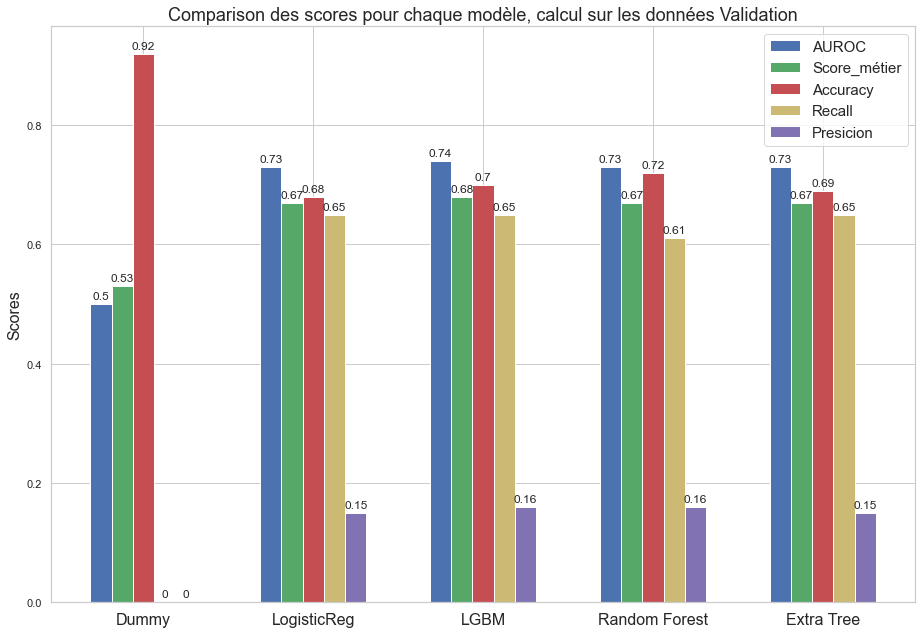

In [297]:
sns.set(style="whitegrid")
df = df_Result_.T
X = np.arange(len(df.columns))
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0,0,1,1])
AUROC = ax.bar(X - 2/8, df.iloc[0, :], color = 'b', width = 1/8, label='AUROC')
Score_metier = ax.bar(X - 1/8, df.iloc[1, :], color = 'g', width = 1/8, label='Score_métier')
Accuracy = ax.bar(X , df.iloc[2, :], color = 'r', width = 1/8, label='Accuracy')
Recall = ax.bar(X + 1/8, df.iloc[3, :], color = 'y', width = 1/8, label='Recall')
Presicion = ax.bar(X + 2/8, df.iloc[4, :], color = 'm', width = 1/8, label='Presicion')
# ax.bar(X + 3/6, df.iloc[5, :], color = 'c', width = 1/6)

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines , labels, loc=0, fontsize=15)

ax.set_ylabel('Scores',fontdict={'fontsize': 16})
ax.set_title('Comparison des scores pour chaque modèle, calcul sur les données Validation',fontdict={'fontsize': 18})
ax.set_xticks(x)
ax.set_xticklabels(df.columns,fontdict={'fontsize': 16})
ax.bar_label(AUROC, padding=3)
ax.bar_label(Score_metier, padding=3)
ax.bar_label(Accuracy, padding=3)
ax.bar_label(Recall, padding=3)
ax.bar_label(Presicion, padding=3)
fig.tight_layout()
plt.show()

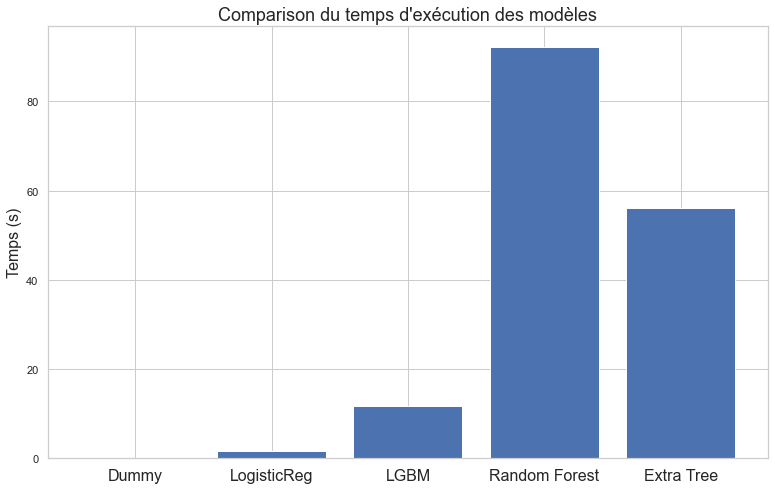

In [301]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df.columns, df.loc['run_time sec', :])
ax.set_title("Comparison du temps d'exécution des modèles",fontdict={'fontsize': 18})
ax.set_ylabel('Temps (s)',fontdict={'fontsize': 16})
ax.set_xticklabels(df.columns,fontdict={'fontsize': 16})
plt.show()

## Etude du seuil

### LogisticRegression

In [243]:
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced')
start_time = timeit.default_timer()
model_lr.fit(X_train_std, Y_train)
print("Time: ", round(timeit.default_timer() - start_time,2))

Time:  1.89


In [244]:
print("Valid  Accuracy : %.2f"%model_lr.score(X_valid_std, Y_valid))
print("Train Accuracy : %.2f"%model_lr.score(X_train_std, Y_train))
print()
print("Confusion Matrix: ")
print(confusion_matrix(Y_valid, model_lr.predict(X_valid_std)))
print()
print("Classification Report:")
print(classification_report(Y_valid, model_lr.predict(X_valid_std)))
print("Score Métier: ", custom_score_(np.array(Y_valid.TARGET), model_lr.predict(X_valid_std)))
print("AUROC: ", roc_auc_score(Y_valid, model_lr.predict_proba(X_valid_std)[:, 1]))

Valid  Accuracy : 0.68
Train Accuracy : 0.68

Confusion Matrix: 
[[63851 29457]
 [ 2853  5317]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80     93308
         1.0       0.15      0.65      0.25      8170

    accuracy                           0.68    101478
   macro avg       0.56      0.67      0.52    101478
weighted avg       0.89      0.68      0.75    101478

Score Métier:  0.67
AUROC:  0.7301188233868761


In [245]:
y_pred_proba = model_lr.predict_proba(X_valid_std)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_valid,  y_pred_proba)

In [246]:
# print("threshold:", "\ttpr: ", "\t\tfpr:", "\t\tScore_metier:")
# for thresholds_, tpr_, fpr_ in zip(thresholds, tpr, fpr):
#     y_pred_thr = np.multiply(y_pred_proba >= thresholds_, 1)
#     score_thr = custom_score_(np.array(Y_valid.TARGET), y_pred_thr)
#     print("%.3f" %thresholds_, "\t\t%.3f" %tpr_, "\t\t%.3f" %fpr_, "\t\t%.2f" %score_thr)

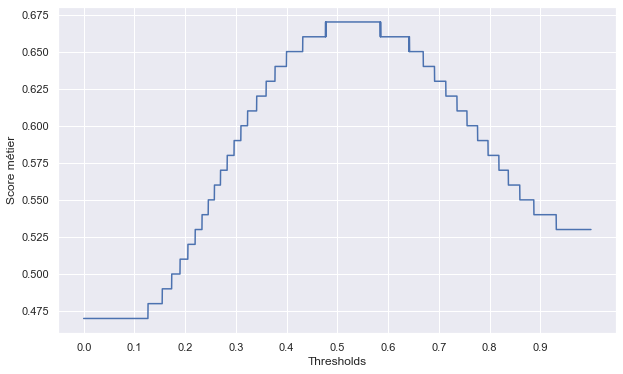

In [247]:
score_thr = []
thresholds_list = np.linspace(0, 1, 10000)
for thresholds_ in thresholds_list:
    y_pred_thr = np.multiply(y_pred_proba >= thresholds_, 1)
    score_thr.append(custom_score_(np.array(Y_valid.TARGET), y_pred_thr))

plt.plot(thresholds_list, score_thr)
plt.xlabel('Thresholds')
plt.xticks(np.arange(0, 1, 0.1))
plt.ylabel('Score métier')
plt.show()

### LGBM

In [248]:
model_lgbm = LGBMClassifier(n_estimators=500, max_depth=8, learning_rate=0.02, class_weight='balanced')
start_time = timeit.default_timer()
model_lgbm.fit(X_train_std, Y_train)
print("Time: ", round(timeit.default_timer() - start_time,2))
y_pred_proba = model_lgbm.predict_proba(X_valid_std)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_valid,  y_pred_proba)

Time:  9.0


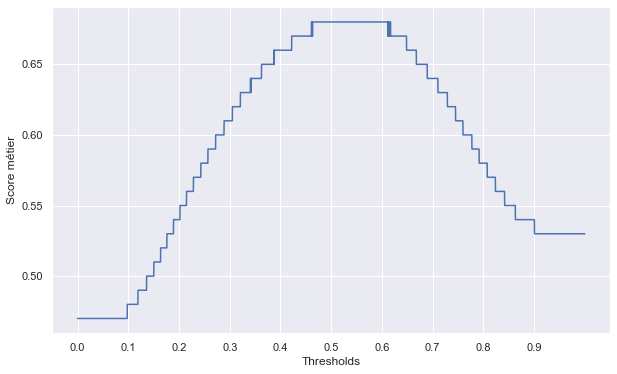

In [249]:
score_thr = []
thresholds_list = np.linspace(0, 1, 10000)
for thresholds_ in thresholds_list:
    y_pred_thr = np.multiply(y_pred_proba >= thresholds_, 1)
    score_thr.append(custom_score_(np.array(Y_valid.TARGET), y_pred_thr))

plt.plot(thresholds_list, score_thr)
plt.xlabel('Thresholds')
plt.xticks(np.arange(0, 1, 0.1))
plt.ylabel('Score métier')
plt.show()

In [250]:
print("Valid  Accuracy : %.2f"%model_lgbm.score(X_valid_std, Y_valid))
print("Train Accuracy : %.2f"%model_lgbm.score(X_train_std, Y_train))
print()
print("Confusion Matrix: ")
print(confusion_matrix(Y_valid, model_lgbm.predict(X_valid_std)))
print()
print("Classification Report:")
print(classification_report(Y_valid, model_lgbm.predict(X_valid_std)))
print("Score Métier: ", custom_score_(np.array(Y_valid.TARGET), model_lgbm.predict(X_valid_std)))
print("AUROC: ", roc_auc_score(Y_valid, model_lgbm.predict_proba(X_valid_std)[:, 1]))

Valid  Accuracy : 0.70
Train Accuracy : 0.71

Confusion Matrix: 
[[65414 27894]
 [ 2820  5350]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     93308
         1.0       0.16      0.65      0.26      8170

    accuracy                           0.70    101478
   macro avg       0.56      0.68      0.53    101478
weighted avg       0.89      0.70      0.77    101478

Score Métier:  0.68
AUROC:  0.742903611518825


# Interprétabilité du modèle

In [211]:
target_names = ['Bon client', 'Client a risque']
feature_names = train_df.drop(columns=["SK_ID_CURR", 'TARGET']).columns

In [212]:
feature_names

Index(['EXT_SOURCE_2', 'PREV_DAYS_DECISION_MEAN',
       'BURO_MONTHS_BALANCE_SIZE_MEAN', 'DAYS_REGISTRATION',
       'PREV_NAME_YIELD_GROUP_low_normal_MEAN',
       'PREV_NAME_YIELD_GROUP_high_MEAN', 'REGION_POPULATION_RELATIVE',
       'PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN',
       'BURO_DAYS_CREDIT_MAX', 'POS_MONTHS_BALANCE_MEAN',
       'BURO_CREDIT_TYPE_Creditcard_MEAN', 'CLOSED_DAYS_CREDIT_MAX',
       'BURO_STATUS_0_MEAN_MEAN', 'HOUR_APPR_PROCESS_START',
       'PREV_NAME_PRODUCT_TYPE_XNA_MEAN',
       'PREV_NAME_SELLER_INDUSTRY_Consumerelectronics_MEAN',
       'CC_AMT_CREDIT_LIMIT_ACTUAL_SUM', 'PREV_NAME_TYPE_SUITE_nan_MEAN',
       'CLOSED_DAYS_CREDIT_MEAN', 'ACTIVE_DAYS_CREDIT_MIN',
       'BURO_DAYS_CREDIT_MIN', 'EXT_SOURCE_3', 'EXT_SOURCE_1',
       'BURO_DAYS_CREDIT_MEAN', 'DAYS_BIRTH', 'BURO_CREDIT_ACTIVE_Active_MEAN',
       'ACTIVE_DAYS_CREDIT_MAX', 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
       'DAYS_LAST_PHONE_CHANGE', 'REFUSED_DAYS_DECISION_MAX',
      

In [213]:
len(feature_names)

33

## Lime values

In [184]:
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(X_train_std, mode="classification",
                                              class_names=['Bon client', 'Client a risque'],
                                              feature_names=feature_names,
                                             )

explainer

In [185]:
model_lr = LogisticRegression(solver='lbfgs', class_weight='balanced')
model_lr.fit(X_train_std, Y_train)

LogisticRegression(class_weight='balanced')

In [206]:
import random
idx = random.randint(1, len(X_valid_std))

print("Prediction : ", target_names[int(model_lr.predict(X_valid_std[idx].reshape(1,-1))[0])])
print("Actual :     ", target_names[int(np.array(Y_valid.TARGET)[idx])])

explanation = explainer.explain_instance(X_valid_std[idx], model_lr.predict_proba, num_features=len(feature_names))
explanation.show_in_notebook()

Prediction :  Bon client
Actual :      Bon client


In [207]:
preds = model_lr.predict(X_valid_std)

false_preds = np.argwhere((preds != np.array(Y_valid.TARGET)[idx])).flatten()

idx  = random.choice(false_preds)

print("Prediction : ", target_names[int(model_lr.predict(X_valid_std[idx].reshape(1,-1))[0])])
print("Actual :     ", target_names[int(np.array(Y_valid.TARGET)[idx])])

explanation = explainer.explain_instance(X_valid_std[idx], model_lr.predict_proba, num_features=len(feature_names))
explanation.show_in_notebook()

Prediction :  Client a risque
Actual :      Bon client


In [222]:
preds = model_lr.predict(X_valid_std)

false_preds = np.argwhere(preds != np.array(Y_valid.TARGET)).flatten()

idx  = random.choice(false_preds)

print("Prediction : ", target_names[int(model_lr.predict(X_valid_std[idx].reshape(1,-1))[0])])
print("Actual :     ", target_names[int(np.array(Y_valid.TARGET)[idx])])

explanation = explainer.explain_instance(X_valid_std[idx], model_lr.predict_proba, num_features=len(feature_names))
explanation.show_in_notebook()

Prediction :  Bon client
Actual :      Client a risque


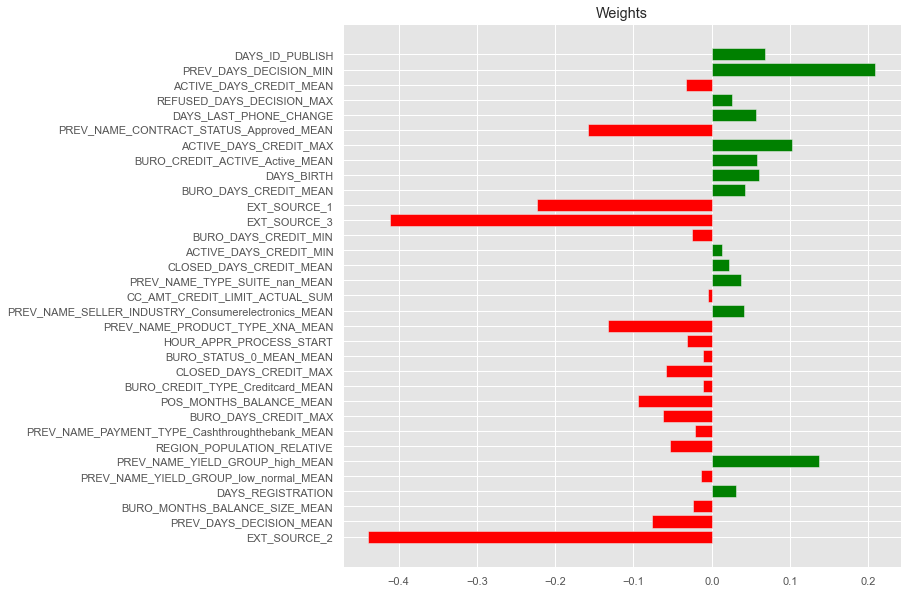

In [224]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(10,10))
    plt.barh(range(len(model_lr.coef_[0])), model_lr.coef_[0], color=["red" if coef<0 else "green" for coef in model_lr.coef_[0]])
    plt.yticks(range(len(model_lr.coef_[0])), feature_names);
    plt.title("Weights")

In [223]:
print("Explanation Local Prediction              : ","Client a risque" if explanation.local_pred<0.5 else "Bon client")
print("Explanation Global Prediction Probability : ", explanation.predict_proba)
print("Explanation Global Prediction             : ", target_names[np.argmax(explanation.predict_proba)])

Explanation Local Prediction              :  Client a risque
Explanation Global Prediction Probability :  [0.61691424 0.38308576]
Explanation Global Prediction             :  Bon client


## Shap values

In [227]:
X_test = X_valid_std

In [226]:
import shap
log_reg_explainer = shap.LinearExplainer(model_lr, X_train_std)

In [230]:
log_reg_explainer.expected_value

-0.27112429216709893

In [231]:
shap_vals

array([-4.94851102e-02, -1.13228916e-02,  3.47238547e-06,  3.80902450e-02,
        7.77927290e-03,  3.74007261e-02, -7.67511530e-03,  2.36923732e-02,
       -2.23164886e-02,  4.82118815e-02,  1.20903249e-03, -7.61074666e-03,
        1.16957196e-03, -2.53841299e-02, -5.80911973e-02, -6.50754708e-03,
        8.61520967e-04, -1.86620691e-02, -1.93374121e-03,  1.17786783e-03,
        4.10208184e-03, -5.98777511e-02,  7.37285289e-01,  9.91883458e-04,
        8.54767178e-02, -2.50322305e-04,  2.45342531e-02,  1.30253831e-01,
       -2.66716572e-02,  1.19170377e-02, -3.10520918e-03, -1.86814740e-01,
        9.81428482e-02])

In [237]:
sample_idx = 0

shap_vals = log_reg_explainer.shap_values(X_test[sample_idx])

val0 = log_reg_explainer.expected_value + shap_vals.sum()

print("Expected/Base Values : ", log_reg_explainer.expected_value)
print()
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("\n")
print("Prediction From Model                            : ", \
                      target_names[int(model_lr.predict(X_test[sample_idx].reshape(1, -1))[0])])
print("Prediction From Adding SHAP Values to Base Value : ", target_names[np.argmax([val0])])

Expected/Base Values :  -0.27112429216709893

Shap Values for Sample 0 :  [-4.94851102e-02 -1.13228916e-02  3.47238547e-06  3.80902450e-02
  7.77927290e-03  3.74007261e-02 -7.67511530e-03  2.36923732e-02
 -2.23164886e-02  4.82118815e-02  1.20903249e-03 -7.61074666e-03
  1.16957196e-03 -2.53841299e-02 -5.80911973e-02 -6.50754708e-03
  8.61520967e-04 -1.86620691e-02 -1.93374121e-03  1.17786783e-03
  4.10208184e-03 -5.98777511e-02  7.37285289e-01  9.91883458e-04
  8.54767178e-02 -2.50322305e-04  2.45342531e-02  1.30253831e-01
 -2.66716572e-02  1.19170377e-02 -3.10520918e-03 -1.86814740e-01
  9.81428482e-02]


Prediction From Model                            :  Client a risque
Prediction From Adding SHAP Values to Base Value :  Bon client
